In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import figure
from ipywidgets import interact
import pandas as pd
from scipy.optimize import fsolve
import oapackage
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, VBox, ButtonStyle, GridBox, SliderStyle
from termcolor import colored
import sys
import os
import json

def pareto_front(x, y, reverse='bottom'):
    if reverse == 'top':
        def reverse_list(l):
            return l
    else:
        def reverse_list(l):
            return [-x for x in l]

    datapoints = np.array([reverse_list(x), reverse_list(y)])
#     print(datapoints)

    pareto = oapackage.ParetoDoubleLong()

    for ii in range(0, datapoints.shape[1]):
        w = oapackage.doubleVector((datapoints[0, ii], datapoints[1, ii]))
        pareto.addvalue(w, ii)

    pareto.show(verbose=1)

    lst = pareto.allindices()  # the indices of the Pareto optimal designs

    optimal_datapoints = datapoints[:, lst]
    return reverse_list(optimal_datapoints[0, :]), reverse_list(optimal_datapoints[1, :])

def plot_settings():
    mpl.rcParams["font.family"] = "cmr10"
    mpl.rcParams['text.usetex'] = False  # Disable LaTeX rendering to use mathtext
    # mpl.rcParams['mathtext.fontset'] = 'cm'
    mpl.rcParams['axes.formatter.use_mathtext'] = True
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16

    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['legend.fontsize'] = 16
    mpl.rcParams['legend.title_fontsize'] = 14

    mpl.rcParams['figure.figsize'] = [12, 6]
    mpl.rcParams['figure.dpi'] = 100

    # Set the desired colormap
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.Set2.colors)
    
plot_settings()

In [2]:
import sys
sys.path.append("..")
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib widget
%matplotlib ipympl
from cavsim2d.cavity import Cavity, Cavities, OperationPoints
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# load shape space
with open(r'D:\Dropbox\CavityDesignHub\PhD_Thesis/Cavities/cavities.json') as f:
    shape_space = json.load(f)

In [4]:

cavs = Cavities('Thesis')
cavs.save('D:\Dropbox\CavityDesignHub\PhD_Thesis\SimulationData')

c3794_shape = shape_space['C3794']
fccuros_shape = shape_space['FCCUROS']

# create cavities
c3794 = Cavity(2, c3794_shape['IC'], c3794_shape['OC'], c3794_shape['OC_R'], beampipe='both', color='#4b8f63')
c3794v2 = Cavity(2, 0.5*np.array(c3794_shape['IC']), 0.5*np.array(c3794_shape['OC']), 0.5*np.array(c3794_shape['OC_R']), beampipe='both', color='#6a7bbf')
fccuros = Cavity(4, fccuros_shape['IC'], fccuros_shape['OC'], fccuros_shape['OC_R'], beampipe='both', color='#fc6d2d')

# add cavities
# cavs.add_cavity([fccuros], ['FCCUROS'],['FCCUROS'])
cavs.add_cavity([c3794, fccuros], ['C3794', 'FCCUROS'], ['C3794', 'FCCUROS'])
# cavs.add_cavity([c3794, c3794v2, fccuros], ['C3794', 'C3794v2', 'FCCUROS'], ['C3794', 'C3794v2', 'FCCUROS'])
# cavs.add_cavity([c3794, c3794v2], ['C3794', 'C3794v2'], ['C3794', 'C3794v2'])

Project D:\Dropbox\CavityDesignHub\PhD_Thesis\SimulationData created successfully/already exists.


In [5]:
eigenmode_config = {
    'processes': 1,
    'rerun': False,
    'boundary_conditions': 'mm',
    'uq_config': {
        'variables': ['A', 'B', 'a', 'b', 'Ri', 'L', 'Req'],
        'objectives': ['freq [MHz]', "Epk/Eacc []", "Bpk/Eacc [mT/MV/m]", "R/Q [Ohm]", "G [Ohm]"],
        'epsilon': [1, 1, 1, 1, 1, 1, 1],
        'processes': 33,
        'method': 'stroud5',
        'cell complexity': 'simplecell'
        }
    }

# wakefield
# OPERATING POINTS
with open(r'D:\Dropbox\CavityDesignHub\PhD_Thesis/OperatingPoints/fcc.json') as f:
    fcc_ee_ops = json.load(f)
op_points = {key: val for key, val in fcc_ee_ops.items() if key in ['Z_2023', 'W_2023', 'H_2023', 'ttbar_2023', 'Z_b_2024_FB', 'W_b_2024_FB', 'H_b_2024_FB', 'ttbar_b_2024_FB']}

wakefield_config = {
    'bunch_length': 25,
    'wakelength': 50,
    'processes': 1,
    'rerun': False,
    'operating_points': op_points,
    'uq_config': {
        'variables': ['A', 'B', 'a', 'b', 'Ri', 'L', 'Req'],
        'epsilon': [1, 1, 1, 1, 1, 1, 1],
        'objectives': [["ZL", [0.44, 0.77, 1.1, 2]], ["ZT", [0.54, 0.59, 0.75, 1.05, 2]], 'k_FM [V/pC]', '|k_loss| [V/pC]', '|k_kick| [V/pC/m]', 'P_HOM [kW]'],
        'processes': 33,
        'method': 'Stroud5',
        'cell complexity': 'simplecell',
        'operating_points': op_points
        }
}

cavs.run_eigenmode(eigenmode_config)
cavs.run_wakefield(wakefield_config)

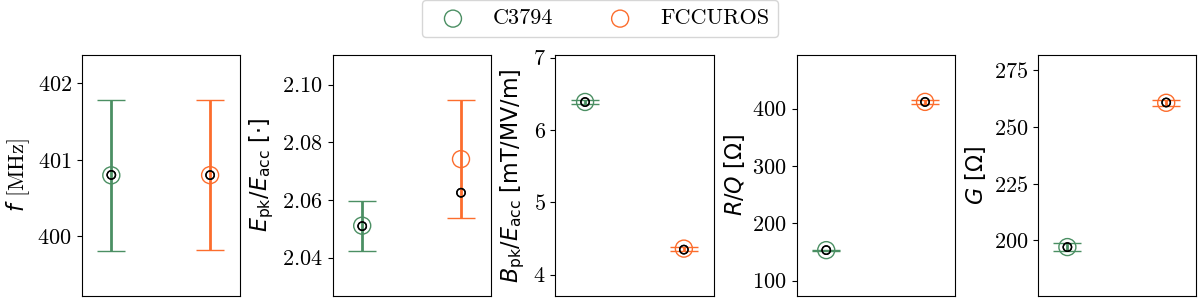

In [6]:
cavs.plot_compare_eigenmode(uq=True)

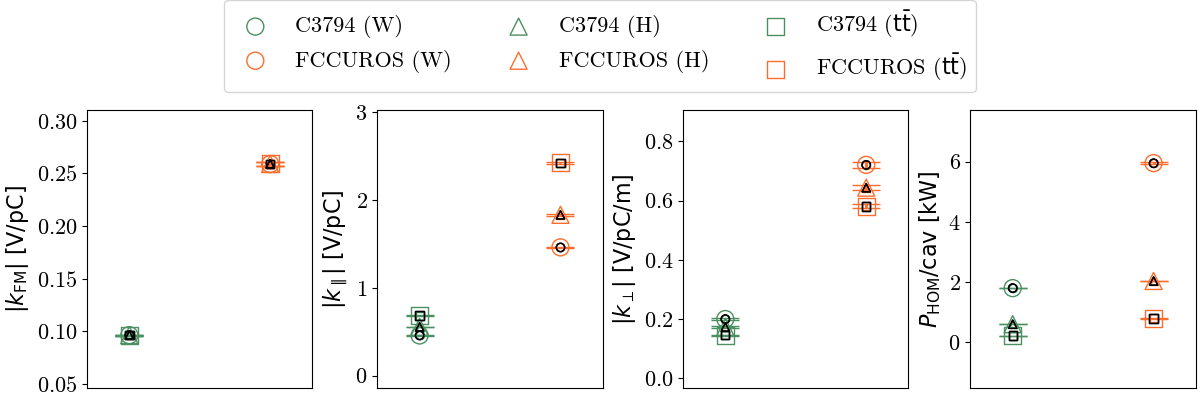

In [7]:
cavs.plot_compare_wakefield(opt=['W_2023', 'H_2023', 'ttbar_2023'], uq=True, ncols=3, figsize=(12, 4))

In [8]:
machine_rf_config = {
    'Eacc [MV/m]': 12,
    'Vrf [GV]': 9.2e9,
    'Q0 []': 3e10,
    'eta []': 745,
    'SR per turn [MW]': 50
}
cavs.plot_compare_power_scatter(['W_2023', 'H_2023', 'ttbar_2023'])

AttributeError: 'Cavity' object has no attribute 'pstat'

In [ ]:
cavs.plot_cavities_contour(opt='end', figsize=(12, 4))

In [ ]:
# cavs.plot_cavities_contour_dimension(opt='end', figsize=(19, 4))

In [9]:
pp.pprint(op_points)

{   'H_2023': {   'E [GeV]': 120,
                  'Eacc [MV/m]': 10.61,
                  'I0 [mA]': 53.4,
                  'N_c []': 264,
                  'Nb [1e11]': 1.51,
                  'T [K]': 4.5,
                  'V [GV]': 2.1,
                  'alpha_p [1e-5]': 0.733,
                  'beta_xy [m]': 50,
                  'f_rev [kHz]': 3.07,
                  'freq [MHz]': 400.79,
                  'nu_s []': 0.0328,
                  'sigma_BS [mm]': 4.45,
                  'sigma_SR [mm]': 2.5,
                  'tau_xy [ms]': 39.2,
                  'tau_z [ms]': 19.6},
    'H_b_2024_FB': {   'E [GeV]': 20,
                       'Eacc [MV/m]': 20.12,
                       'I0 [mA]': 2.01328375,
                       'N_c []': 108,
                       'Nb [1e11]': 0.1,
                       'T [K]': 2,
                       'V [GV]': 0.0501,
                       'alpha_p [1e-5]': 0.712,
                       'beta_xy [m]': 61,
                       'f_r